In [6]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *

In [9]:
def plot_image(img):
    img = img.astype(np.uint8)
    img_new = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_new, cmap = 'gray')
    # plt.axis('off')

def symprint(symbol, sup, sub, dot=False):
    if dot == 1:
        symbol = r'\dot{%s}' % symbol
    elif dot == 2:
        symbol = r'\ddot{%s}' % symbol
    if sup == '':
        info = r"{}_{}".format(symbol, sub)
    else:
        info = r"^{}{}_{}".format(sup, symbol, sub)
    display(symbols(info))

(3680, 5224, 3)


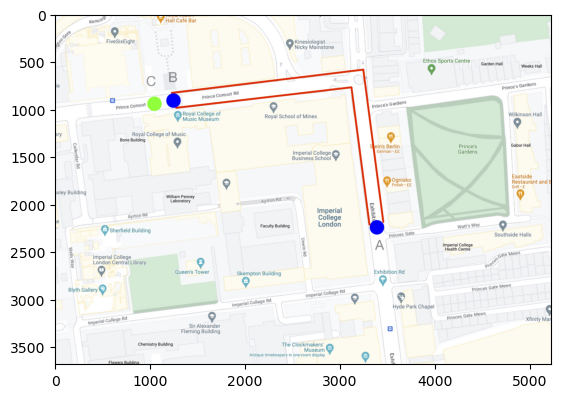

In [3]:
#read image
img = cv2.imread('CWMap.jpg', cv2.IMREAD_UNCHANGED)
print(img.shape)
fig, ax = plt.subplots()
plot_image(img)

In [4]:

def extract_color(color, plot = False):
    # Load the image
    img = cv2.imread('CWMap.jpg')

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    if color == 'red' or color == 'r':
        
        # Define a range of HSV values for the red color
        lower_red = np.array([0, 50, 50])
        upper_red = np.array([10, 255, 255])
        mask1 = cv2.inRange(hsv, lower_red, upper_red)

        lower_red = np.array([170, 50, 50])
        upper_red = np.array([180, 255, 255])
        mask2 = cv2.inRange(hsv, lower_red, upper_red)

        # Combine the masks
        red_extracted = cv2.bitwise_or(mask1, mask2)

        if plot == True:
            plot_image(red_extracted)
            plt.show()
        return red_extracted
    
    elif color == 'green' or color == 'g':
        # Define range of green color in HSV
        lower_green = (40, 50, 50)
        upper_green = (80, 255, 255)

        # Threshold the HSV image to get only green colors
        mask = cv2.inRange(hsv, lower_green, upper_green)

        # Apply bitwise AND operation to the original image
        # and the mask to extract green color
        green_extracted = cv2.bitwise_and(img, img, mask=mask)

        green_extracted[:,:,:][green_extracted[:,:,:]<250] = 0
        green_extracted[:,:,:][green_extracted[:,:,:]>250] = 255

        # BGR
        green_extracted = green_extracted[:,:,1]

        if plot == True:
            plot_image(green_extracted)
            plt.show()
        return green_extracted
    
    elif color == 'blue' or color == 'b':
        # Define range of blue color in HSV
        lower_blue = (100, 50, 50)
        upper_blue = (130, 255, 255)

        # Threshold the HSV image to get only blue colors
        mask = cv2.inRange(hsv, lower_blue, upper_blue)

        # Apply bitwise AND operation to the original image
        # and the mask to extract blue color
        blue_extracted = cv2.bitwise_and(img, img, mask=mask)

        blue_extracted[:,:,:][blue_extracted[:,:,:]<250] = 0
        blue_extracted[:,:,:][blue_extracted[:,:,:]>250] = 255

        # BGR
        blue_extracted = blue_extracted[:,:,0]
        
        if plot == True:
            plot_image(blue_extracted)
            plt.show()
        return blue_extracted


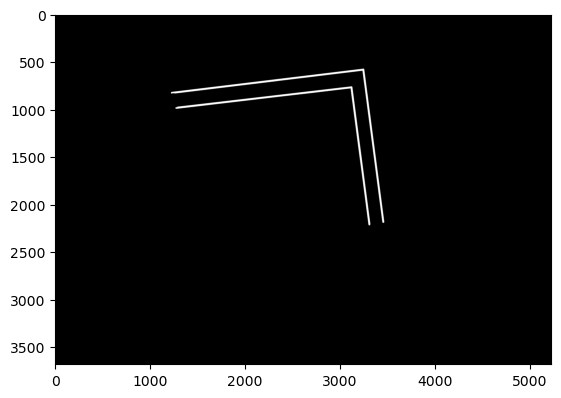

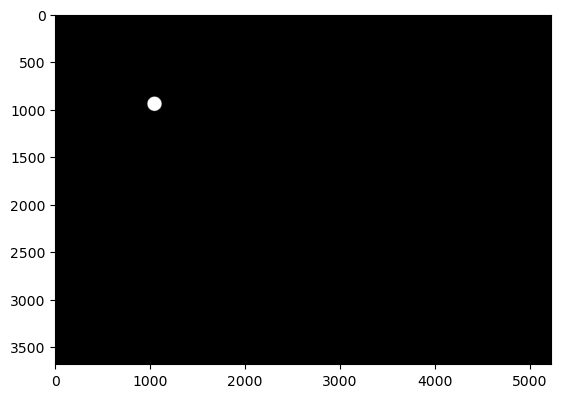

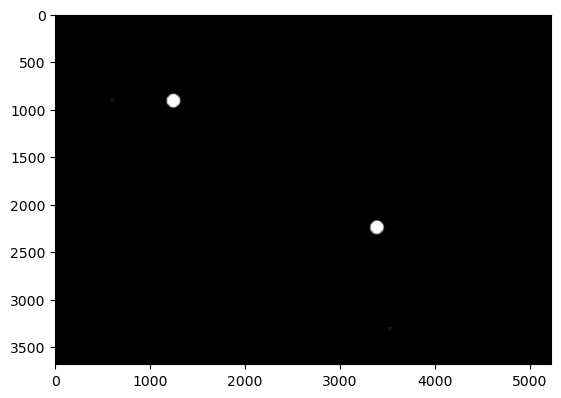

In [5]:
red_extracted = extract_color('r', True)
green_extracted = extract_color('g', True)
blue_extracted = extract_color('b', True)

In [6]:
def post_process_red(red_extracted):
    row_indices, col_indices = np.nonzero(red_extracted)

    # There an unexpected point appearing on the top left corner of the image, remove it

    num_to_be_removed = len(row_indices[row_indices<100])
    row_indices = row_indices[num_to_be_removed:]
    col_indices = col_indices[num_to_be_removed:]

    row_indices = height - row_indices
    
    return col_indices, row_indices

def post_process_green(green_extraced):
    row_indices, col_indices = np.nonzero(green_extracted)

    height, width = green_extracted.shape
    row_indices = height - row_indices
    
    return col_indices, row_indices, np.mean(col_indices), np.mean(row_indices)

def post_process_blue(blue_extracted):
    
    row_indices, col_indices = np.nonzero(blue_extracted)

    height, width = green_extracted.shape
    row_indices = height - row_indices

    row_indices_new = row_indices[(row_indices>500) & (col_indices>800)]
    col_indices_new = col_indices[(row_indices>500) & (col_indices>800)]

    row_indices_new[(row_indices_new<2650) & (col_indices_new<1500)] = 0
    col_indices_new[(row_indices_new<2650) & (col_indices_new<1500)] = 0
    
    end_point_y = np.mean(row_indices_new[:15500])
    end_point_x = np.mean(col_indices_new[:15500])

    start_point_y = np.mean(row_indices_new[15500:])
    start_point_x = np.mean(col_indices_new[15500:])
    
    return col_indices_new, row_indices_new, end_point_x, end_point_y, start_point_x, start_point_y
    

In [7]:
alpha = {'RL': pi/2,
        'RR': -pi/2,
        'F': 0}

beta = {'RL': 0,
        'RR': pi,
        'F': symbols('f(t)')}

# Rear left 1 (fixed standard)
symprint('Rear-wheel-left','', '')
RL1 = Matrix([[sin(alpha['RL'] + beta['RL']), -cos(alpha['RL'] + beta['RL']), -symbols('W')/2*cos(beta['RL'])]])
display(RL1)
# Rear left 2 (fixed standard)
RL2 = Matrix([[cos(alpha['RL'] + beta['RL']), sin(alpha['RL'] + beta['RL']), symbols('W')/2*sin(beta['RL'])]])
display(RL2)

# Rear right 1 (fixed standard)
symprint('Rear-wheel-right','', '')
RR1 = Matrix([[sin(alpha['RR'] + beta['RR']), -cos(alpha['RR'] + beta['RR']), -symbols('W')/2*cos(beta['RR'])]])
display(RR1)
# Rear right 2 (fixed standard)
RR2 = Matrix([[cos(alpha['RR'] + beta['RR']), sin(alpha['RR'] + beta['RR']), symbols('W')/2*sin(beta['RR'])]])
display(RR2)

# Front 1 (steerable standard)
symprint('Front-wheel-right','', '')
F1 = Matrix([[sin(alpha['F'] + beta['F']), -cos(alpha['F'] + beta['F']), -symbols('L')*cos(beta['F'])]])
display(F1)
# Front 2 (steerable standard)
F2 = Matrix([[cos(alpha['F'] + beta['F']), sin(alpha['F'] + beta['F']), symbols('L')*sin(beta['F'])]])
display(F2)

# Rear right, rear left 1, rear left 2
symprint('Rolling-condition-matrix','', '')
M = Matrix([RR1, RL1, RL2])
display(M)

Rear-wheel-left_

Matrix([[1, 0, -W/2]])

Matrix([[0, 1, 0]])

Rear-wheel-right_

Matrix([[1, 0, W/2]])

Matrix([[0, 1, 0]])

Front-wheel-right_

Matrix([[sin(f(t)), -cos(f(t)), -L*cos(f(t))]])

Matrix([[cos(f(t)), sin(f(t)), L*sin(f(t))]])

Rolling-condition-matrix_

Matrix([
[1, 0,  W/2],
[1, 0, -W/2],
[0, 1,    0]])

In [8]:
# Forward kinematics 
# Given wheel speeds, return car speed in the global coordinate

def forward_kinematics(M, phi_r, phi_l, theta, Display = False):
    # Rotational speed of the wheels
    phi = Matrix([symbols('\dot{\phi_r}'), symbols('\dot{\phi_l}')])

    # Rotational matrix from 0 to I
    R_0I = Matrix([[cos(symbols('theta')), -sin(symbols('theta')), 0],
               [sin(symbols('theta')), cos(symbols('theta')), 0],
               [0, 0, 1]])

    r = Matrix([[symbols('r'),0], [0, symbols('r')], [0, 0]])

    PI = R_0I * M**-1 * r * phi

    result = PI.subs({'W': 40, 'r': 4, '\dot{\phi_r}': phi_r, '\dot{\phi_l}': phi_l, 'theta': theta})
    
    if Display == True:
        display(R_0I)
        display(M**-1 * r * phi) # Check with slides
        display(PI)
    
    # x_dot, y_dot, theta_dot
    return [float(result[0]), float(result[1]), float(result[2])]
    
forward_kinematics(M, 25.011705145543683, 24.394768589407153, 1.7074649240077648, True)

Matrix([
[cos(theta), -sin(theta), 0],
[sin(theta),  cos(theta), 0],
[         0,           0, 1]])

Matrix([
[ \dot{\phi_l}*r/2 + \dot{\phi_r}*r/2],
[                                   0],
[-\dot{\phi_l}*r/W + \dot{\phi_r}*r/W]])

Matrix([
[\dot{\phi_l}*r*cos(theta)/2 + \dot{\phi_r}*r*cos(theta)/2],
[\dot{\phi_l}*r*sin(theta)/2 + \dot{\phi_r}*r*sin(theta)/2],
[                     -\dot{\phi_l}*r/W + \dot{\phi_r}*r/W]])

[-13.462625570951117, 97.8915537747048, 0.06169365561365314]

In [9]:
# Inverse kinematics (see Mobile robot slide 11) 
# Given car speed in the global coordinate, return wheel speeds

def inverse_kinematics(M, x_dot, y_dot, theta_dot, theta, Display = False):
    r = Matrix([[symbols('r'),0], [0, symbols('r')], [0, 0]])
    
    # Rotational matrix from 0 to I
    R_0I = Matrix([[cos(symbols('theta')), -sin(symbols('theta')), 0],
                   [sin(symbols('theta')), cos(symbols('theta')), 0],
                   [0, 0, 1]])
    
    # Rotational matrix from I to 0
    R_I0 = R_0I.T
    
    PI = Matrix([symbols('\dot{x}'), symbols('\dot{y}'), symbols('\dot{\\theta}')])
    wheel_vel = (r.T * r)**-1 * r.T * M * R_I0 * PI
    
    result = wheel_vel.subs({'W': 40, 'r': 4, '\dot{x}': x_dot, '\dot{y}': y_dot, 
                             '\dot{\\theta}': theta_dot, 'theta': theta})
    
    if Display == True:
        display(r)
        display((r.T * r)**-1)
        display(r.T * M)
        display((r.T * r)**-1 * r.T * M)
        display(R_I0)
        display(PI)
        display(wheel_vel)
    
    # phi_right, and phi_left
    return [float(result[0]), float(result[1])]


inverse_kinematics(M, -73.65517554415354, -9.621729766818026, 0, 3.757493882200789, True)

Matrix([
[r, 0],
[0, r],
[0, 0]])

Matrix([
[r**(-2),       0],
[      0, r**(-2)]])

Matrix([
[r, 0,  W*r/2],
[r, 0, -W*r/2]])

Matrix([
[1/r, 0,  W/(2*r)],
[1/r, 0, -W/(2*r)]])

Matrix([
[ cos(theta), sin(theta), 0],
[-sin(theta), cos(theta), 0],
[          0,          0, 1]])

Matrix([
[     \dot{x}],
[     \dot{y}],
[\dot{\theta}]])

Matrix([
[ W*\dot{\theta}/(2*r) + \dot{x}*cos(theta)/r + \dot{y}*sin(theta)/r],
[-W*\dot{\theta}/(2*r) + \dot{x}*cos(theta)/r + \dot{y}*sin(theta)/r]])

[16.41992196881112, 16.41992196881112]

Green marker (start) coordinate: (1048, 2737)
Blue marker (start) coordinate: (3387, 1440)
Blue marker (end) coordinate: (1247, 2770)


(1000.0, 3500.0)

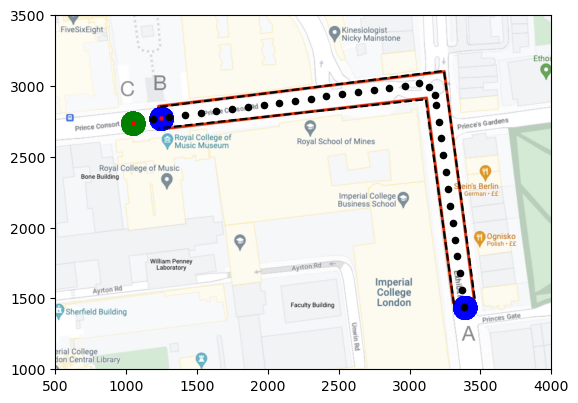

In [10]:
# Invert the raw image vertically
im = plt.imread("CWMap.jpg")[::-1]
im = plt.imshow(im)
height, width = red_extracted.shape

# Plot green point
col_indices_g, row_indices_g, x_g, y_g = post_process_green(green_extracted)
plt.scatter(col_indices_g, row_indices_g, c='g', s=1)
plt.scatter(x_g,y_g, s=5, c='r')
plt.ylim([0, height])
plt.xlim([0, width])
print(f'Green marker (start) coordinate: {round(x_g), round(y_g)}')

# Plot blue point
col_indices_b, row_indices_b, end_point_x, end_point_y, start_point_x, start_point_y = post_process_blue(blue_extracted)
plt.scatter(col_indices_b, row_indices_b, c='b', s=1)
plt.scatter(end_point_x, end_point_y, s=5, c='r')
plt.scatter(start_point_x, start_point_y, s=5, c='r')
print(f'Blue marker (start) coordinate: {round(start_point_x), round(start_point_y)}')
print(f'Blue marker (end) coordinate: {round(end_point_x), round(end_point_y)}')
# Plot red line
col_indices_r, row_indices_r = post_process_red(red_extracted)

# col_indices becomes the x-value of the plot and row_indices becomes the y-value of the plot 
# plt.scatter(col_indices_r, row_indices_r, c='r', s=1)

height, width = red_extracted.shape

plt.ylim([0, height])
plt.xlim([0, width])

end_point_1 = [1228, 2700]
end_point_2 = [1220, 2850]
start_point_1 = [3314, 1458]
start_point_2 = [3460, 1500]
turn_point_1 = [3115, 2905]
turn_point_2 = [3243, 3106]

plt.plot([start_point_1[0], turn_point_1[0], end_point_1[0]],
        [start_point_1[1], turn_point_1[1], end_point_1[1]], c = 'black', linestyle='dashed')

plt.plot([start_point_2[0], turn_point_2[0], end_point_2[0]],
        [start_point_2[1], turn_point_2[1], end_point_2[1]], c = 'black', linestyle='dashed')


# Trip 1
x_distance_1 = turn_point_1[0] - start_point_1[0]
y_distance_1 = turn_point_1[1] - start_point_1[1]
grad_1 = y_distance_1/x_distance_1
distance_1 = np.sqrt(y_distance_1**2 + x_distance_1**2)

# Trip 2
grad_2 = (turn_point_1[1] - end_point_1[1])/(turn_point_1[0] - end_point_1[0])

x_lst = [start_point_x]
y_lst = [start_point_y]
theta_lst = [np.arctan2(y_distance_1, x_distance_1)]

x_dot_lst, y_dot_lst, theta_dot_lst = [], [], []

# plt.title(f'x_dot = 0 pixel/s \n y_dot = 0 pixel/s \n theta_dot = 0 degree/s')
# plt.scatter(x_lst,y_lst, marker = 'o', s = 20, c = 'black') 
# plt.xlim([500, 4000])
# plt.ylim([1000, 3500])
# plt.savefig(f'robot_trip_0_label.png')


# Assume t1 = 12s
t1 = 12
for i in range(t1):
    x_dot, y_dot, theta_dot = forward_kinematics(M, 30, 30, theta_lst[-1]) # 60 60 
    
    x_dot_lst.append(x_dot)
    y_dot_lst.append(y_dot)
    theta_dot_lst.append(theta_dot)
    
    # distance = speed * time, in each iteration, time is 1s
    x_lst.append(x_lst[-1] + x_dot * 1)
    y_lst.append(y_lst[-1] + y_dot * 1)
    theta_lst.append(theta_lst[-1])
    
#     plt.title(f'x_dot = {round(x_dot, 1)} pixel/s \n y_dot = {round(y_dot, 1)} pixel/s \n theta_dot = {round(np.degrees(theta_dot), 1)} degree/s')
#     plt.scatter(x_lst,y_lst, marker = 'o', s = 20, c = 'black') 
#     plt.xlim([500, 4000])
#     plt.ylim([1000, 3500])
#     plt.savefig(f'robot_trip_1_{i}_label.png')
    
angle = np.degrees(np.arctan(np.abs(grad_1 - grad_2)/np.abs(1+grad_1*grad_2)))

for i in range(3): 
    x_dot, y_dot, theta_dot = forward_kinematics(M, 21, 15.5, theta_lst[-1]) # 35, 25

    theta_lst.append(theta_lst[-1] + theta_dot * 1)
    x_lst.append(x_lst[-1] + x_dot * 1)
    y_lst.append(y_lst[-1] + y_dot * 1)
    
    x_dot_lst.append(x_dot)
    y_dot_lst.append(y_dot)
    
    theta_dot_lst.append(theta_dot)
    
#     plt.title(f'x_dot = {round(x_dot, 1)} pixel/s \n y_dot = {round(y_dot, 1)} pixel/s \n theta_dot = {round(np.degrees(theta_dot), 1)} degree/s')
#     plt.scatter(x_lst,y_lst, marker = 'o', s = 20, c = 'black') 
#     plt.xlim([500, 4000])
#     plt.ylim([1000, 3500])
#     plt.savefig(f'robot_trip_2_{i}_label.png')


# Mild correction of turning angle after the 90 degree turn|
x_dot, y_dot, theta_dot = forward_kinematics(M, 24.15, 25, theta_lst[-1]) # 26.15 25

theta_lst.append(theta_lst[-1] + theta_dot * 1)
x_lst.append(x_lst[-1] + x_dot * 1)
y_lst.append(y_lst[-1] + y_dot * 1)

x_dot_lst.append(x_dot)
y_dot_lst.append(y_dot)

theta_dot_lst.append(theta_dot)

# plt.title(f'x_dot = {round(x_dot, 1)} pixel/s \n y_dot = {round(y_dot, 1)} pixel/s \n theta_dot = {round(np.degrees(theta_dot), 1)} degree/s')
# plt.scatter(x_lst,y_lst, marker = 'o', s = 20, c = 'black') 
# plt.xlim([500, 4000])
# plt.ylim([1000, 3500])
# plt.savefig(f'robot_trip_2_{i+1}_label.png')


# Trip 3

# Assume t1 = 15s
t3 = 16
for i in range(t3):
    x_dot, y_dot, theta_dot = forward_kinematics(M, 28, 28, theta_lst[-1]) # 58 58
    
    x_dot_lst.append(x_dot)
    y_dot_lst.append(y_dot)
    theta_dot_lst.append(theta_dot)
    
    # distance = speed * time, in each iteration, time is 1s
    x_lst.append(x_lst[-1] + x_dot * 1)
    y_lst.append(y_lst[-1] + y_dot * 1)
    theta_lst.append(theta_lst[-1])
    
#     plt.title(f'x_dot = {round(x_dot, 1)} pixel/s \n y_dot = {round(y_dot, 1)} pixel/s \n theta_dot = {round(np.degrees(theta_dot), 1)} degree/s')
#     plt.scatter(x_lst,y_lst, marker = 'o', s = 20, c = 'black') 
#     plt.xlim([500, 4000])
#     plt.ylim([1000, 3500])
#     plt.savefig(f'robot_trip_3_{i}_label.png')
    

plt.scatter(x_lst,y_lst, marker = 'o', s = 20, c = 'black') 
plt.xlim([500, 4000])
plt.ylim([1000, 3500])
# plt.savefig('No background.png')


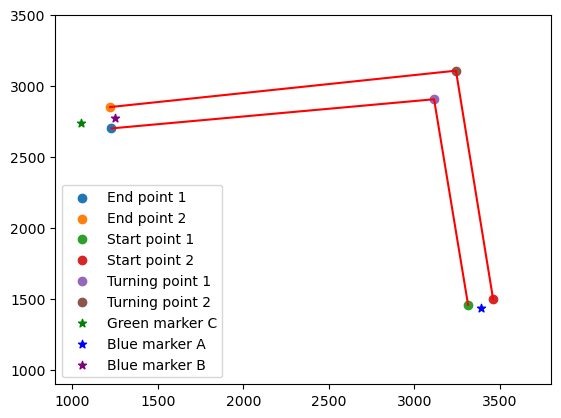

In [11]:
# Plot critical points on the map

end_point_1 = [1228, 2700]
end_point_2 = [1220, 2850]
start_point_1 = [3314, 1458]
start_point_2 = [3460, 1500]
turn_point_1 = [3115, 2905]
turn_point_2 = [3243, 3106]

plt.plot([start_point_1[0], turn_point_1[0], end_point_1[0]],
        [start_point_1[1], turn_point_1[1], end_point_1[1]], c = 'r')

plt.plot([start_point_2[0], turn_point_2[0], end_point_2[0]],
        [start_point_2[1], turn_point_2[1], end_point_2[1]], c = 'r')

plt.scatter(end_point_1[0], end_point_1[1], label = 'End point 1')
plt.scatter(end_point_2[0], end_point_2[1], label = 'End point 2')
plt.scatter(start_point_1[0], start_point_1[1], label = 'Start point 1')
plt.scatter(start_point_2[0], start_point_2[1], label = 'Start point 2')
plt.scatter(turn_point_1[0], turn_point_1[1], label = 'Turning point 1')
plt.scatter(turn_point_2[0], turn_point_2[1], label = 'Turning point 2')
plt.scatter(1048, 2737, marker = '*', c = 'g', label = 'Green marker C')
plt.scatter(3387, 1440, marker = '*', c = 'b', label = 'Blue marker A')
plt.scatter(1247, 2770, marker = '*', c = 'purple', label = 'Blue marker B')
plt.xlim(900, 3800)
plt.ylim(900, 3500)

plt.legend()


## Verify with Inverse Kinematics

In [12]:
print(f'At time = 0s,  right wheel speed = 0 rad/s, left wheel speed = 0 rad/s')
for i in range(len(x_dot_lst)):
    [phi_right, phi_left] = inverse_kinematics(M, x_dot_lst[i], 
                                               y_dot_lst[i], 
                                               theta_dot_lst[i], 
                                               theta_lst[i], Display = False)
    print(f'At time = {i + 1}s,  right wheel speed = {round(phi_right,2)} rad/s, left wheel speed = {round(phi_left,2)} rad/s')

At time = 0s,  right wheel speed = 0 rad/s, left wheel speed = 0 rad/s
At time = 1s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 2s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 3s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 4s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 5s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 6s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 7s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 8s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 9s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 10s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 11s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At time = 12s,  right wheel speed = 30.0 rad/s, left wheel speed = 30.0 rad/s
At

# Trajectory Planning

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from sympy import *

In [83]:
def Tlink(DH):
    # This function calculates the Homogeneous Transformation matrix for a
    # link, receiving as input the DH parameters for the link
    # DH parameters are in the form of an array with: link length, link
    # twist, joint offset, joint angle

    # Set: a:link length; alpha:link twist; d:joint offset; theta:joint
    # angle
    a = DH[0]; alpha = DH[1]; d = DH[2]; theta = DH[3];

    # Set a 4x4 symbolic T matrix 
    T = zeros(4)
    # Line 1
    T[0,0] = cos(theta); T[0,1] = -sin(theta); T[0,2] = 0; T[0,3] = a;
    # Line 2
    T[1,0] = sin(theta)*cos(alpha); T[1,1] = cos(theta)*cos(alpha); 
    T[1,2] = -sin(alpha); T[1,3] = -sin(alpha)*d;
    # Line 3
    T[2,0] = sin(theta)*sin(alpha); T[2,1] = cos(theta)*sin(alpha); 
    T[2,2] = cos(alpha); T[2,3] = cos(alpha)*d;
    # Line 4
    T[3,0] = 0; T[3,1] = 0; T[3,2] = 0; T[3,3] = 1;

    return T

    
def Position_finder(sym_matrix):
    # exclude the last row and display the last column
    return sym_matrix[:-1,-1]

In [84]:
# Adjust the DH paramaters of the manipulator

DH1 = [0, 0, 0, symbols('theta1')]
T01 = Tlink(DH1)
symprint('T',0, 1)
display(T01)

DH2 = [0, 0,  20 + symbols('d2'), 0]
T12 = Tlink(DH2)
symprint('T',1, 2)
display(T12)

DH3 = [0, -pi/2,  symbols('d3'), 0]
T23 = Tlink(DH3)
symprint('T',2, 3)
display(T23)

DH4 = [0, 0, 25, symbols('theta4')]
T34 = Tlink(DH4)
symprint('T',3, 4)
display(T34)

DHE = [-1, 0, 15, -pi]
T4E = Tlink(DHE)
symprint('T',4,'E')
display(T4E)

symprint('T', 0, 'E')
display(simplify(T01*T12*T23*T34*T4E))

display('The position of the end effector')
pos = Position_finder(simplify(T01*T12*T23*T34*T4E))
display(Position_finder(simplify(T01*T12*T23*T34*T4E)))

pos.subs({'theta1':0, 'd2' : 0, 'd3': 0, 'theta4': 0})

^0T_1

Matrix([
[cos(theta1), -sin(theta1), 0, 0],
[sin(theta1),  cos(theta1), 0, 0],
[          0,            0, 1, 0],
[          0,            0, 0, 1]])

^1T_2

Matrix([
[1, 0, 0,       0],
[0, 1, 0,       0],
[0, 0, 1, d2 + 20],
[0, 0, 0,       1]])

^2T_3

Matrix([
[1,  0, 0,  0],
[0,  0, 1, d3],
[0, -1, 0,  0],
[0,  0, 0,  1]])

^3T_4

Matrix([
[cos(theta4), -sin(theta4), 0,  0],
[sin(theta4),  cos(theta4), 0,  0],
[          0,            0, 1, 25],
[          0,            0, 0,  1]])

^4T_E

Matrix([
[-1,  0, 0, -1],
[ 0, -1, 0,  0],
[ 0,  0, 1, 15],
[ 0,  0, 0,  1]])

^0T_E

Matrix([
[-cos(theta1)*cos(theta4), sin(theta4)*cos(theta1), -sin(theta1), -d3*sin(theta1) - 40*sin(theta1) - cos(theta1)*cos(theta4)],
[-sin(theta1)*cos(theta4), sin(theta1)*sin(theta4),  cos(theta1),  d3*cos(theta1) - sin(theta1)*cos(theta4) + 40*cos(theta1)],
[             sin(theta4),             cos(theta4),            0,                                      d2 + sin(theta4) + 20],
[                       0,                       0,            0,                                                          1]])

'The position of the end effector'

Matrix([
[-d3*sin(theta1) - 40*sin(theta1) - cos(theta1)*cos(theta4)],
[ d3*cos(theta1) - sin(theta1)*cos(theta4) + 40*cos(theta1)],
[                                     d2 + sin(theta4) + 20]])

Matrix([
[-1],
[40],
[20]])

In [85]:
def s(x):
    return np.sin(x)

def c(x):
    return np.cos(x)

# Transformation from 0 to End-effector
def T0E(t1, d2, d3, t4, degree = True):
    if degree == True:
        t1 = np.radians(t1)
        t4 = np.radians(t4)

    DH1 = [0, 0, 0, symbols('theta1')]
    T01 = Tlink(DH1)

    DH2 = [0, 0,  20 + symbols('d2'), 0]
    T12 = Tlink(DH2)

    DH3 = [0, -pi/2,  symbols('d3'), 0]
    T23 = Tlink(DH3)

    DH4 = [0, 0, 25, symbols('theta4')]
    T34 = Tlink(DH4)

    DHE = [-1, 0, 15, -pi]
    T4E = Tlink(DHE)

    matrix = simplify(T01*T12*T23*T34*T4E)

    return np.array(matrix.subs({'theta1':t1, 'd2' : d2, 'd3': d3, 'theta4': t4})).astype(np.int32)


# Cubic trajectory planning
def cubic_trajectory(points, joint_type, joint_num):
    
    # Revolute
    if joint_type == 'r':
        points = np.radians(points)
        ylabel = f'$\\theta_{joint_num}$'
        ylabel_disp = f'{ylabel} displacement [{r"$rad$"}]'
        ylabel_vel = f'{ylabel} velocity [{r"$rad/s$"}]'
        ylabel_acc = f'{ylabel} acceleration [{r"$rad/s^2$"}]'
    
    # Prismatic
    elif joint_type == 'p':
        ylabel = f'$d_{joint_num}$'
        ylabel_disp = f'{ylabel} displacement [{r"$cm$"}]'
        ylabel_vel = f'{ylabel} velocity [{r"$cm/s$"}]'
        ylabel_acc = f'{ylabel} acceleration [{r"$cm/s^2$"}]'
        
    f = plt.figure(figsize=(18,4))
    ax = f.add_subplot(131)
    ax2 = f.add_subplot(132)
    ax3 = f.add_subplot(133)

    tf = 2 # Each movement is restricted to 2s
    t_res = 15 # Resolution in time
    t = np.arange(0, len(points)*tf, tf)
    
    # Compute the slope
    slope = (points[1:] - points[0:-1])/tf

    # Set the velocity based on the slope changes
    vel = np.zeros(12)
    for i in range(1, len(points)-1):
        if slope[i] * slope[i-1] < 0:
            vel[i] = 0
        else:
            vel[i] = 0.5 * (slope[i] + slope[i-1])

    # Initialise the displacement, velocity, acceleration and time array
    disp_all = np.zeros(0)
    vel_all = np.zeros(0)
    acc_all = np.zeros(0)
    t_all = np.zeros(0)

    for j in range(len(points)-1):
        
        # Apply formulae in Chapter 6 equation 8
        a0 = points[j]
        a1 = vel[j]
        a2 = 3/tf**2*(points[j+1]-points[j])-2/tf*vel[j]-1/tf*vel[j+1]
        a3 = -2/tf**3*(points[j+1]-points[j])+1/tf**2*(vel[j+1]+vel[j])

        # Time interpolation
        t_plot = np.linspace(t[j], t[j+1], t_res)
    
        # Apply formulae in Chapter 6 equation 2 and 3
        dis_segment = a0 + a1*(t_plot-t[j]) + a2*(t_plot-t[j])**2 + a3*(t_plot-t[j])**3
        vel_segment = a1 + 2*a2*(t_plot-t[j]) + 3*a3*(t_plot-t[j])**2
        acc_segment = 2*a2 + 6*a3*(t_plot-t[j])
        
        # Plot the via points
        ax.scatter([t_plot[0]], [dis_segment[0]], marker='x', color = 'red')
        ax2.scatter([t_plot[0]], [vel_segment[0]], marker='x', color = 'red')
        ax3.scatter([t_plot[0]], [acc_segment[0]], marker='x', color = 'red')

        # Add the disp_segment to the disp_all
        disp_all = np.concatenate([disp_all, dis_segment])
        vel_all = np.concatenate([vel_all, vel_segment])
        acc_all = np.concatenate([acc_all, acc_segment])
        t_all = np.concatenate([t_all, t_plot])
    
    # Plot the last via point
    ax.scatter([t_plot[-1]], [dis_segment[-1]], marker='x', color = 'red')
    ax2.scatter([t_plot[-1]], [vel_segment[-1]], marker='x', color = 'red')
    ax3.scatter([t_plot[-1]], [acc_segment[-1]], marker='x', color = 'red')

    # Plot displacement
    ax.plot(t_all, disp_all)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel(ylabel_disp)

    # Plot velocity
    ax2.plot(t_all, vel_all)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel(ylabel_vel)
    
    # Plot acceleration
    ax3.plot(t_all, acc_all)
    ax3.set_xlabel('Time [s]')
    ax3.set_ylabel(ylabel_acc)
    
    return disp_all


Coordinate of starting point is x = -1, y = 40, z = 20
Coordinate of final point is x = 80, y = 1, z = 20


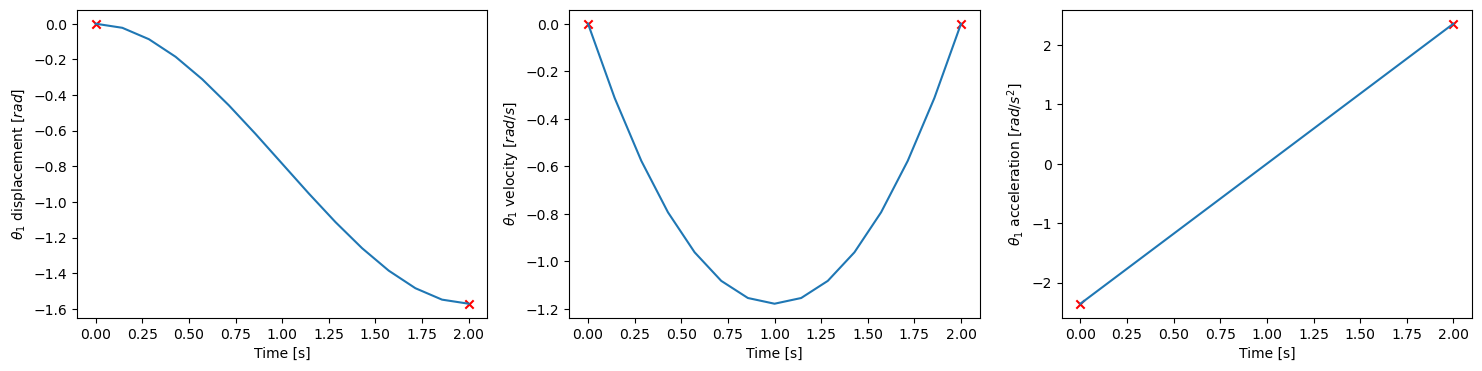

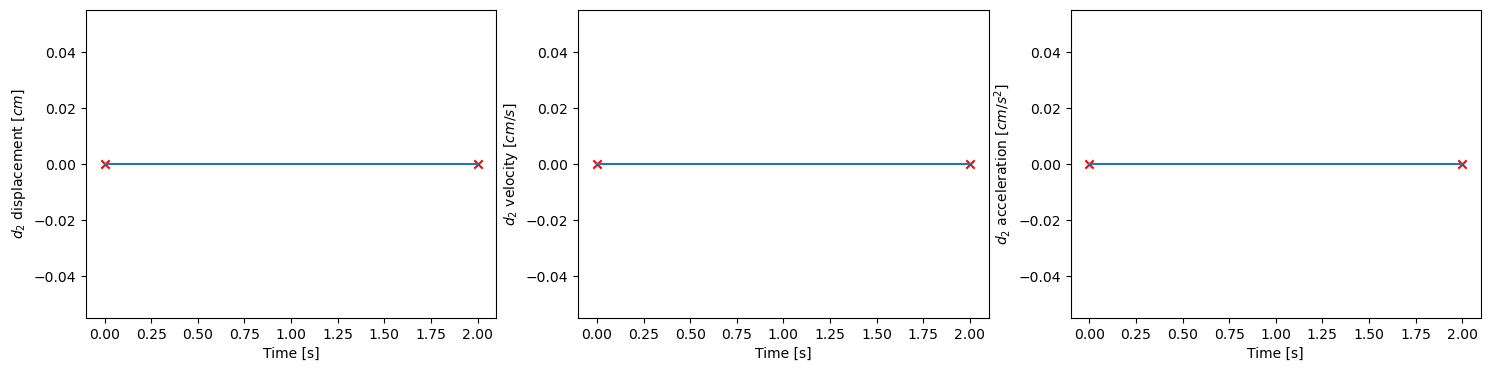

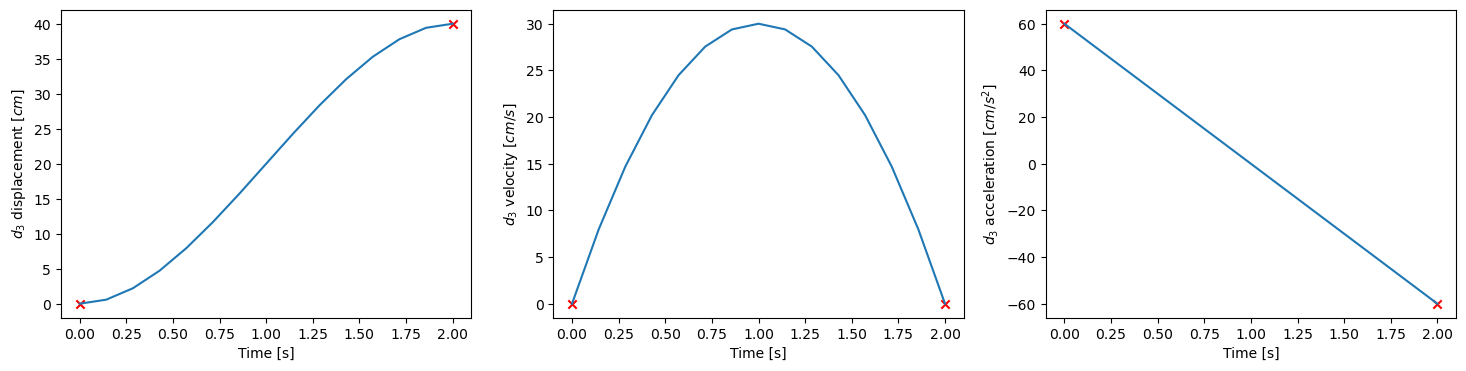

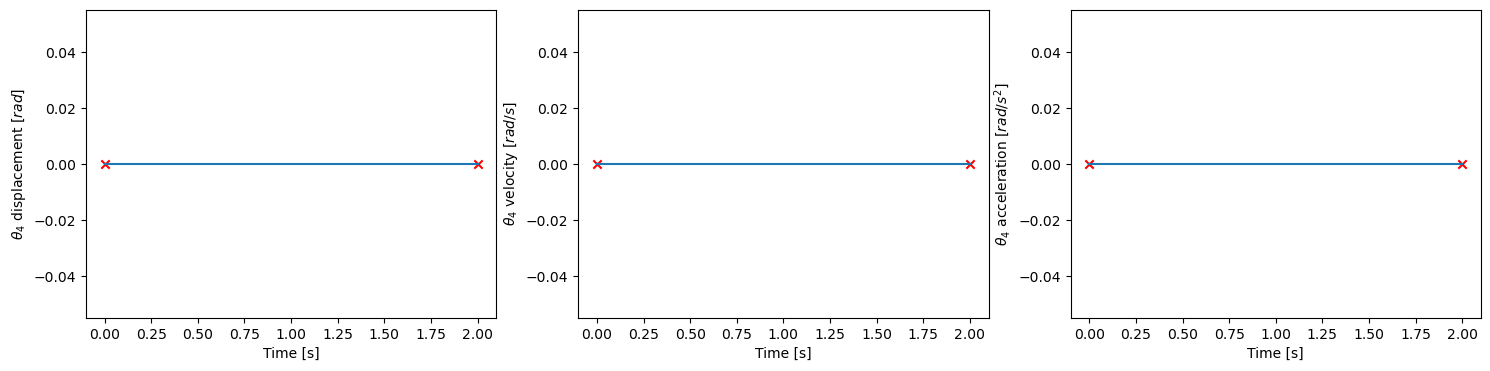

In [86]:
# End points are selected
t1 = np.array([0,  -90])
d2 = np.array([0,  0 ])
d3 = np.array([0,  40])
t4 = np.array([0,  0])

# Initialise the coordinate of each via points
X, Y, Z = [], [], []
for i in range(len(t1)):
    # Extract the coordinate of X, Y and Z from the transformation matrix
    x, y, z = T0E(t1[i], d2[i], d3[i], t4[i])[:3, -1]
    X.append(x)
    Y.append(y)
    Z.append(z)
    
    if i == 0:
        message = 'starting point'
    elif i == len(t1)-1:
        message = 'final point'
    else:
        message = f'via point {i}'
    
    # Print the coordinates
    print(f'Coordinate of {message} is x = {round(x, 2)}, y = {round(y, 2)}, z = {round(z, 2)}')
    
# Create 3D plot
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='markers',
                                       marker=dict(size=2, color='red', symbol='x')))

t1_disp = cubic_trajectory(points = t1, joint_type = 'r', joint_num = 1)
d2_disp = cubic_trajectory(points = d2, joint_type = 'p', joint_num = 2)
d3_disp = cubic_trajectory(points = d3, joint_type = 'p', joint_num = 3)
t4_disp = cubic_trajectory(points = t4, joint_type = 'r', joint_num = 4)


In [67]:
# Get the 3d coorinate of the end-effector trace
x_trace, y_trace, z_trace = [], [], []
for i in range(len(t1_disp)):
    xt, yt, zt = T0E(t1_disp[i], d2_disp[i], d3_disp[i], t4_disp[i], degree = False)[:3, -1]
    x_trace.append(xt)
    y_trace.append(yt)
    z_trace.append(zt)
    
# Get the 3d coorinate of the via points
X_via, Y_via, Z_via = [], [], []
for i in range(len(t1)):
    # Extract the coordinate of X, Y and Z from the transformation matrix
    x, y, z = T0E(t1[i], d2[i], d3[i], t4[i])[:3, -1]
    X_via.append(x)
    Y_via.append(y)
    Z_via.append(z)
    

# Create 3D plot
fig2 = go.Figure()
# fig.add_trace(px.scatter_3d(df, x='X', y='Y', z='Z', labels = 'Via points'))
fig2.add_trace(go.Scatter3d(x=[X_via[0]], y=[Y_via[0]], z=[Z_via[0]], mode='markers',
                                       marker=dict(size=5, color='green', symbol='diamond'), name = 'Starting point'))
fig2.add_trace(go.Scatter3d(x=[X_via[-1]], y=[Y_via[-1]], z=[Z_via[-1]], mode='markers',
                                       marker=dict(size=5, color='green', symbol='square'), name = 'Ending point'))
fig2.add_trace(go.Scatter3d(x=X_via[1:-1], y=Y_via[1:-1], z=Z_via[1:-1], mode='markers',
                                       marker=dict(size=3, color='red', symbol='x'), name = 'Via points'))
fig2.add_trace(go.Scatter3d(x=x_trace, y=y_trace, z=z_trace, mode='markers',
                                       marker=dict(size=2, color='blue', symbol='circle'), name = 'Actual trajectory'))